In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from tensorflow.keras.utils import plot_model
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()
# Set seeds for reproducibility
seed_value = 128
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
df = pd.read_csv("Electric_Production.csv", index_col='DATE', parse_dates=True)
df.columns = ["Production"]

In [3]:
df.isnull().sum()

Production    0
dtype: int64

In [4]:
df1 = df.to_numpy()

In [5]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=7, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

X_in, X_out = truncate(df1, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=12, test_len=1)
print(X_in.shape, X_out.shape)

(385, 12, 1) (385, 1, 1)


In [6]:
train_x = X_in[:math.floor(X_in.shape[0]*0.70)]
train_y = X_out[:math.floor(X_out.shape[0]*0.70)]
test_x = X_in[math.floor(X_in.shape[0]*0.70):]
test_y = X_out[math.floor(X_out.shape[0]*0.70):]

In [7]:
r = 0.5      
q = 0.95
delta = 0.072
l = 2

def confidance_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f1 = y_pred[:, 0]
    f2 = y_pred[:, 1]

    c1 = (1 - q) * (y_true - f2)
    c2 = (1 - q) * (f1 - y_true)
    c3 = q * (f2 - y_true)
    c4 = q * (y_true - f1)

    loss = K.switch(tf.math.logical_and((y_true <= f1), (y_true >= f2)),
                    K.switch((y_true > r * (f1 + f2)), c1, c2),
                    K.switch((f2 > y_true), c3, c4)) + (delta * tf.math.abs(f1 - f2))

    return loss

In [8]:
input_train = Input(shape=(12, 1))
initializer = tf.keras.initializers.GlorotNormal(seed=128)
lstm_l1 = LSTM(64, activation='relu', kernel_initializer=initializer, return_sequences=False)(input_train)
out = Dense(2)(lstm_l1)
model = Model(inputs=input_train, outputs=out)


opt = Adam(learning_rate=0.01)


model.compile(loss=confidance_loss, optimizer=opt)
plot_model(model, show_shapes=True, show_layer_names=True)


# Training the model
epc = 300
start_time = datetime.datetime.now()
stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
history = model.fit(train_x, train_y, validation_split=0.1, epochs=epc, verbose=1, batch_size=64,callbacks = [early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
print('seconds taken:', round(total_time.total_seconds(), 1),
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/300
4/4 [==============================] - 2s 109ms/step - loss: 88.0946 - val_loss: 19.7031
Epoch 2/300
4/4 [==============================] - 0s 15ms/step - loss: 13.7521 - val_loss: 4.3683
Epoch 3/300
4/4 [==============================] - 0s 15ms/step - loss: 9.7807 - val_loss: 3.8622
Epoch 4/300
4/4 [==============================] - 0s 15ms/step - loss: 4.4833 - val_loss: 8.0964
Epoch 5/300
4/4 [==============================] - 0s 16ms/step - loss: 6.9867 - val_loss: 8.3500
Epoch 6/300
4/4 [==============================] - 0s 15ms/step - loss: 6.3107 - val_loss: 6.1925
Epoch 7/300
4/4 [==============================] - 0s 15ms/step - loss: 4.2801 - val_loss: 3.3251
Epoch 8/300
4/4 [==============================] - 0s 15ms/step - loss: 2.4217 - val_loss: 2.4419
Epoch 9/300
4/4 [==============================] - 0s 15ms/step

PICP: 0.9568965517241379
MPIW: 18.136


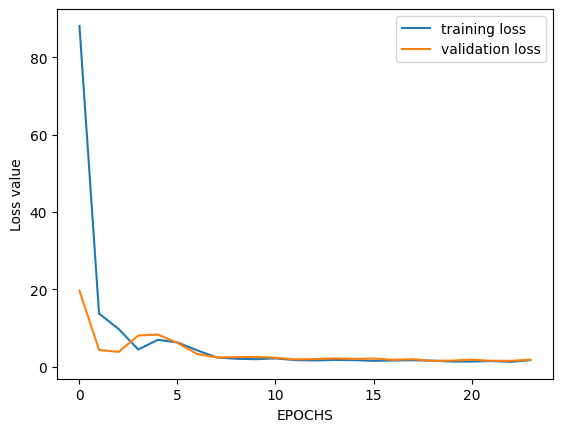

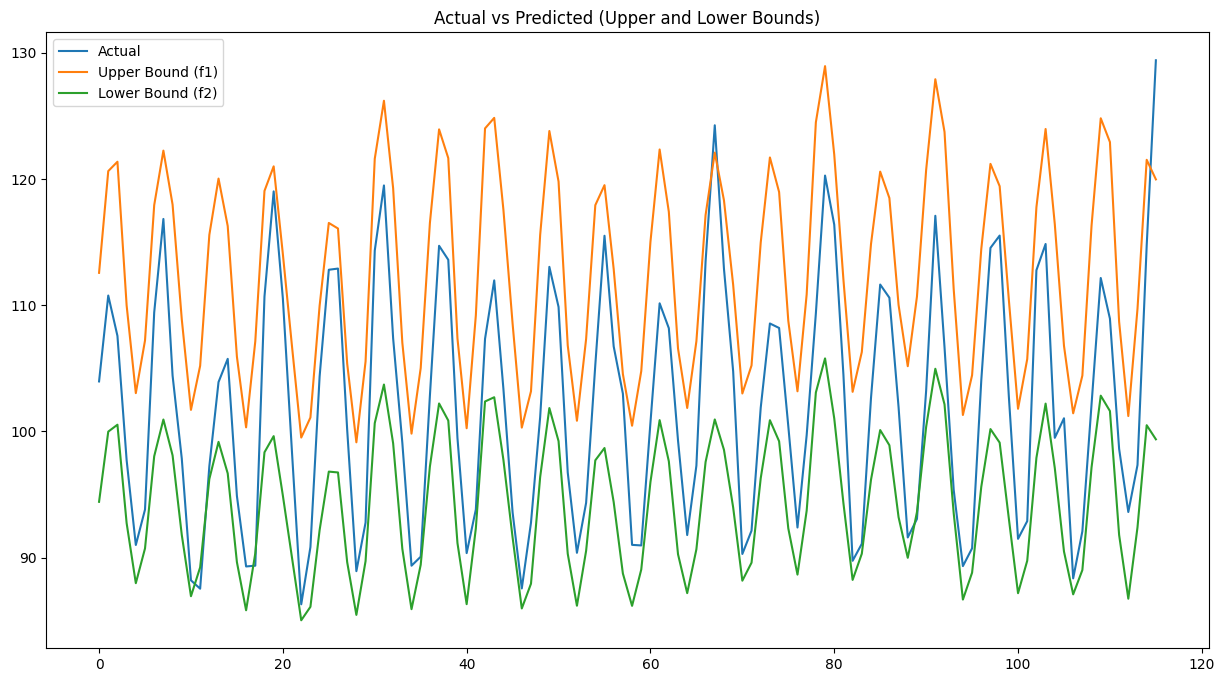

In [9]:
# Plot training and validation loss
fig, ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend()

# Predict on test data
y_pred = model.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y[:, 0])
y_u_pred = y_pred[:, 0]
y_l_pred = y_pred[:, 1]

# Calculate PICP and MPIW
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_

print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred), 3))

actual = np.squeeze(test_y)
pred1 = y_u_pred
pred2 = y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx, actual, label='Actual')
plt.plot(numEx, pred1, label='Upper Bound (f1)')
plt.plot(numEx, pred2, label='Lower Bound (f2)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Upper and Lower Bounds)')
plt.show()